In [2]:
from networkModules.modelUnet3pShort import UNet_3PlusShort
from networkModules.modelUnet3p import UNet_3Plus
from networkModules.modelElunet import ELUnet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from sklearn.decomposition import PCA

import os

from auxilary.utils import *
from auxilary.lossFunctions import *

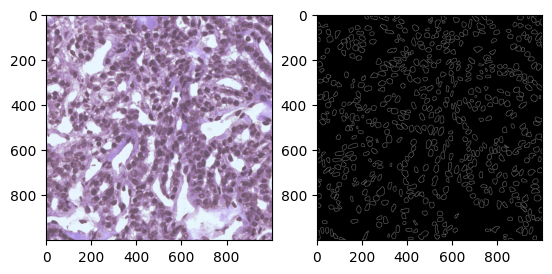

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Read the image using OpenCV
image_path = 'Dataset/test_c/0.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

label_path = 'Dataset/test_c/0_label.png'
label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(label, 100, 200)

# plot image and label side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(edges, cmap='gray')
plt.show()

# Preprocess the image and label
image = cv2.resize(image, (256, 256))
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
image = image.unsqueeze(0)  # Add a batch dimension
image = image.to(device)

edges = cv2.resize(edges, (256, 256))
edges = np.reshape(edges, (1, 256, 256))
edges = torch.tensor(edges, dtype=torch.float32)
edges = edges.unsqueeze(0)  # Add a batch dimension
edges = edges.to(device)



In [23]:
# Load Model

mode = 'image' # 'edge' or 'image'

loadPretrained = True
if loadPretrained:
    expt_dir = 'Outputs/experiment_12-22_14.40.24/'
    config = json.load(open(os.path.join(expt_dir, 'config.json'), 'r'))

    if mode == 'edge':
        config['input_img_type'] = 'gray'

    weightPath = os.path.join(expt_dir, 'model/best_model.pth')
    print("weight: ", weightPath)

    model = UNet_3PlusShort(config)
    checkpoint = torch.load(weightPath)
    model.load_state_dict(checkpoint['model_state_dict'])

else:
    config = readConfig('config.sys')
    if mode == 'edge':
        config['input_img_type'] = 'gray'
    model = UNet_3PlusShort(config)

model.to(device)
model.eval()
print(config)

weight:  Outputs/experiment_12-22_14.40.24/model/best_model.pth
{'log': 'log/', 'debug': False, 'debugDilution': 20, 'wandb': True, 'normalization': 'reinhard', 'targetImagePath': 'Dataset/MonuSegData/Training/TissueImages/TCGA-A7-A13F-01Z-00-DX1.png', 'to_be_aug': 'Dataset/MonuSegData/', 'split_dir': 'Dataset/MonuSegData/split2/', 'out_dir': 'Dataset/MonuSegData/slidingAugNormal/', 'tileHeight': 800, 'tileWidth': 800, 'slidingSize': 50, 'augmentPerImage': 100, 'finalTileHeight': 256, 'finalTileWidth': 256, 'splitRatio': 0.7, 'trainDataset': 'Dataset/trainNormal3/', 'valDataset': 'Dataset/valNormal3/', 'testDataset': 'Dataset/testNormal/', 'resumeModel': 'model/best_model.pth', 'sampleImages': False, 'dinoModelType': 'giga', 'reUseFeatures': True, 'batchVisualization': True, 'trainingPhase': 'high-density', 'class1': [0, 0, 0], 'class2': [255, 255, 255], 'model_type': 'UNet_3PlusShort', 'input_img_type': 'rgb', 'kernel_size': 3, 'use_maxblurpool': False, 'epochs': 50, 'batch_size': 16,

In [5]:
def apply_pca(features):
    # Reshape the tensor to 2D array
    features_2d = features.view(features.shape[0], -1).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(features_2d.T).T
    
    # Reshape back to original spatial dimensions but with 3 channels
    pca_result = pca_result.reshape(3, features.shape[1], features.shape[2])
    
    return torch.tensor(pca_result, dtype=torch.float32)



def apply_single_component_pca(features):
    # Reshape the tensor to 2D array
    features_2d = features.view(features.shape[0], -1).cpu().numpy()
    
    # Apply PCA
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(features_2d.T).T
    
    # Reshape back to original spatial dimensions but with 1 channel
    pca_result = pca_result.reshape(1, features.shape[1], features.shape[2])
    
    return torch.tensor(pca_result, dtype=torch.float32)


In [6]:
def max_pooling(features):
    max_pooled, _ = features.max(dim=0, keepdim=True)
    return torch.cat([max_pooled]*3, dim=0)

def average_pooling(features):
    avg_pooled = features.mean(dim=0, keepdim=True)
    return torch.cat([avg_pooled]*3, dim=0)



# Function to visualize the features
def save_features(features, filename='Outputs/visualization2/features.png', conversion_func=average_pooling):
    features = features.cpu()[0]  # Move tensor to CPU and take first batch
    features = conversion_func(features)  # Convert to RGB
    min_val = float(features.min())
    max_val = float(features.max())
    features.clamp_(min=min_val, max=max_val)
    features.add_(-min_val).div_(max_val - min_val + 1e-5)
    out_image = torchvision.utils.make_grid(features.unsqueeze(0), nrow=8)
    plt.imshow(out_image.permute(1, 2, 0).cpu().numpy())  # Convert to numpy array
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


def save_features_g(features, filename='Outputs/visualization2/features.png', conversion_func=average_pooling):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    features = conversion_func(features)  # Convert to single channel using PCA
    min_val = float(features.min())
    max_val = float(features.max())
    features.clamp_(min=min_val, max=max_val)
    features.add_(-min_val).div_(max_val - min_val + 1e-5)
    plt.imshow(features.squeeze().cpu().numpy(), cmap='gray')  # Display in grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

def save_grayscale_features(features, filename='Outputs/visualization2/features.png'):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    avg_pooled = features.mean(dim=0, keepdim=True)  # Average pooling across channels
    min_val = float(avg_pooled.min())
    max_val = float(avg_pooled.max())
    avg_pooled.clamp_(min=min_val, max=max_val)
    avg_pooled.add_(-min_val).div_(max_val - min_val + 1e-5)
    plt.imshow(avg_pooled.squeeze(0), cmap='gray')  # Show as grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

def save_single_channel(features, channel_index, filename):
    features = features.cpu()[0]  # Move tensor to CPU and take the first batch
    single_channel = features[channel_index, :, :]  # Select the channel
    plt.imshow(single_channel, cmap='gray')  # Show as grayscale
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


"f_channel = [32, 64, 128, 128]\nfor layer in [1, 2, 3, 4]:\n    for channel in range(f_channel[layer-1]):\n        save_single_channel(activation['conv%d' % layer], channel, 'Outputs/visualization/all_features/layer%d/layer%d_fc_%d.png' % (layer, layer, channel))\n"

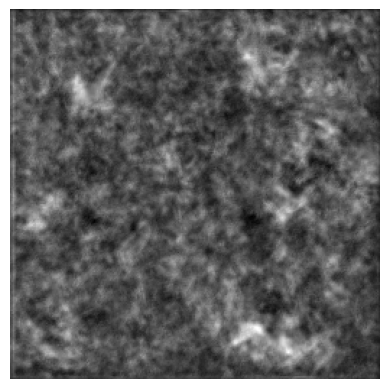

In [24]:
# Register hooks for the layers you want to visualize
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))

model.conv4d_1.register_forward_hook(get_activation('conv4d_1'))
model.conv3d_1.register_forward_hook(get_activation('conv3d_1'))
model.conv2d_1.register_forward_hook(get_activation('conv2d_1'))
model.outconv1.register_forward_hook(get_activation('outconv1'))

# Forward pass to get the output and populate 'activation'
with torch.no_grad():
    if mode == 'edge':
        output = model(edges)
    else:
        output = model(image)

# Visualize the features
'''save_features(activation['conv1'], 'Outputs/visualization/layer1_v3.png', apply_pca)
save_features(activation['conv2'], 'Outputs/visualization/layer2_v3.png', apply_pca)
save_features(activation['conv3'], 'Outputs/visualization/layer3_v3.png', apply_pca)
save_features(activation['conv4'], 'Outputs/visualization/layer4_v3.png', apply_pca)
save_features(activation['conv4d_1'], 'Outputs/visualization/layer4d_1_v3.png', apply_pca)
save_features(activation['conv3d_1'], 'Outputs/visualization/layer3d_1_v3.png', apply_pca)
save_features(activation['conv2d_1'], 'Outputs/visualization/layer2d_1_v3.png', apply_pca)
save_features(activation['outconv1'], 'Outputs/visualization/layer_outconv1_v3.png', apply_pca)'''


# Visualize the features
save_features_g(activation['conv1'], f'Outputs/visualization2/s1_{mode}_enc1_v3.png', apply_single_component_pca)
save_features_g(activation['conv2'], f'Outputs/visualization2/s2_{mode}_enc2_v3.png', apply_single_component_pca)
save_features_g(activation['conv3'], f'Outputs/visualization2/s3_{mode}_enc3_v3.png', apply_single_component_pca)
save_features_g(activation['conv4'], f'Outputs/visualization2/s4_{mode}_enc4_v3.png', apply_single_component_pca)
save_features_g(activation['conv4d_1'], f'Outputs/visualization2/s5_{mode}_decv1_v3.png', apply_single_component_pca)
save_features_g(activation['conv3d_1'], f'Outputs/visualization2/s6_{mode}_decv2_1_v3.png', apply_single_component_pca)
save_features_g(activation['conv2d_1'], f'Outputs/visualization2/s7_{mode}_decv3_1_v3.png', apply_single_component_pca)
save_features_g(activation['outconv1'], f'Outputs/visualization2/s8_{mode}_decv4_v3.png', apply_single_component_pca)

'''save_grayscale_features(activation['conv1'], 'Outputs/visualization/layer1_v4.png')
save_grayscale_features(activation['conv2'], 'Outputs/visualization/layer2_v4.png')
save_grayscale_features(activation['conv3'], 'Outputs/visualization/layer3_v4.png')
save_grayscale_features(activation['conv4'], 'Outputs/visualization/layer4_v4.png')
save_grayscale_features(activation['conv4d_1'], 'Outputs/visualization/layer4d_1_v4.png')
save_grayscale_features(activation['conv3d_1'], 'Outputs/visualization/layer3d_1_v4.png')
save_grayscale_features(activation['conv2d_1'], 'Outputs/visualization/layer2d_1_v4.png')
save_grayscale_features(activation['outconv1'], 'Outputs/visualization/layer_outconv1_v4.png')'''

'''f_channel = [32, 64, 128, 128]
for layer in [1, 2, 3, 4]:
    for channel in range(f_channel[layer-1]):
        save_single_channel(activation['conv%d' % layer], channel, 'Outputs/visualization/all_features/layer%d/layer%d_fc_%d.png' % (layer, layer, channel))
'''